#코드 설명
1. 라이브러리 임포트 및 버전 확인: TensorFlow와 ImageIO의 버전을 확인합니다.
2. 작업환경 구성: 필요한 디렉토리를 생성합니다.
3. 데이터셋 로드 및 정규화: CIFAR-10 데이터를 로드하고 이미지를 [-1, 1]로 정규화합니다.
4. 데이터셋 변환: TensorFlow의 tf.data.Dataset API를 사용하여 배치 데이터셋을 만듭니다.
5. 생성자 모델 구현: 랜덤 노이즈를 받아 이미지를 생성하는 모델을 정의합니다.
6. 판별자 모델 구현: 이미지를 받아 진짜와 가짜를 판별하는 모델을 정의합니다.
7. 손실 함수 및 최적화 함수 정의: 생성자와 판별자의 손실 함수를 정의하고 옵티마이저를 설정합니다.
8. 훈련 과정 구현: 훈련 스텝을 정의하여 생성자와 판별자를 동시에 업데이트합니다.
9. 이미지 생성 및 저장: 훈련 중 생성된 이미지를 저장하는 함수를 정의합니다.
10. 훈련 기록 시각화: 손실 및 정확도를 시각화하는 함수를 정의합니다.
11. 체크포인트 설정: 모델을 저장하고 불러오는 기능을 설정합니다.
12. 모델 학습 실행: 모델을 학습시키고 결과를 시각화합니다.
13. GIF 파일 생성: 생성된 이미지를 애니메이션으로 변환합니다.

In [ ]:
# STEP 1: 라이브러리 임포트 및 버전 확인
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time  # 시간 측정을 위한 모듈
import glob  # 파일 경로 다루기 위한 모듈
from IPython import display  # 출력 지연을 위한 모듈

# TensorFlow 및 ImageIO 버전 확인
print("TensorFlow version:", tf.__version__)
print("ImageIO version:", imageio.__version__)

TensorFlow version: 2.18.0
ImageIO version: 2.37.0


In [ ]:
# STEP 2: 작업환경 구성
# 홈 디렉토리 경로를 사용하여 올바르게 디렉토리 생성
# 필요한 디렉토리 생성
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/generated_samples', exist_ok=True)
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/training_checkpoints', exist_ok=True)
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/training_history', exist_ok=True)

In [ ]:
# STEP 3: 데이터셋 구성
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

In [ ]:
# 데이터 정규화
train_x = (train_x.astype('float32') - 127.5) / 127.5  # [-1, 1] 범위로 정규화
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(10000).batch(64)

In [ ]:
# STEP 4: 생성자 모델 구현
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256 * 8 * 8, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2DTranspose(3, kernel_size=5, activation='tanh', padding='same'))

    return model

generator = build_generator()

In [ ]:
# 랜덤 노이즈로 이미지 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise)
print("Generated image shape:", generated_image.shape)

Generated image shape: (1, 32, 32, 3)


In [ ]:
# STEP 5: 판별자 모델 구현
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()

In [ ]:
# 랜덤 이미지로 판별자 결과 확인
decision = discriminator(generated_image)
print("Discriminator decision on generated image:", decision)

Discriminator decision on generated image: tf.Tensor([[0.49958378]], shape=(1, 1), dtype=float32)


In [ ]:
# STEP 6: 손실 함수 및 최적화 함수 구현
def generator_loss(fake_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# STEP 7: 훈련 과정 구현
@tf.function
def train_step(images):
    noise = tf.random.normal([64, 100])  # 배치 크기를 64로 설정

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# STEP 8: 이미지 생성 및 저장 함수
def generate_and_save_images(model, epoch, examples=16):
    noise = tf.random.normal([examples, 100])
    generated_images = model(noise)

    plt.figure(figsize=(4, 4))
    for i in range(examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)  # [-1, 1]을 [0, 1]로 변환
        plt.axis('off')
    plt.savefig(os.path.expanduser(f'~/aiffel/dcgan_newimage/cifar10/generated_samples/epoch_{epoch}.png'))
    plt.show()

In [ ]:
# STEP 9: 훈련 기록 시각화 함수
def draw_train_history(history, epoch):
    plt.figure(figsize=(12, 6))

    # 손실 시각화
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label='Real Accuracy')
    plt.plot(history['fake_accuracy'], label='Fake Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(os.path.expanduser(f'~/aiffel/dcgan_newimage/cifar10/training_history/train_history_{epoch}.png'))
    plt.show()

In [ ]:
# STEP 10: 체크포인트 설정
checkpoint_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# STEP 11: 훈련 과정 실행
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            history['gen_loss'].append(gen_loss.numpy())
            history['disc_loss'].append(disc_loss.numpy())
            # 정확도 계산 (필요한 경우)
            real_accuracy = tf.reduce_mean(discriminator(image_batch, training=False)).numpy()
            fake_accuracy = tf.reduce_mean(discriminator(generator(tf.random.normal([64, 100]), training=False), training=False)).numpy()
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, 16)  # 요청하는 이미지 수는 16
                print('Epoch {} | Iteration {}'.format(epoch + 1, it + 1))
                print('Time for epoch {}: {} sec'.format(epoch + 1, int(time.time() - epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, 16)  # 요청하는 이미지 수는 16
        print('Time for training: {} sec'.format(int(time.time() - start)))

        draw_train_history(history, epoch)

save_every = 5
EPOCHS = 50  # 에포크 수 설정

In [ ]:
# 사용 가능한 GPU 디바이스 확인
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


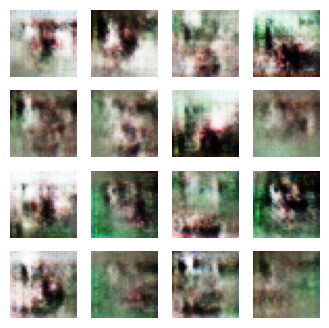

Time for training: 2982 sec


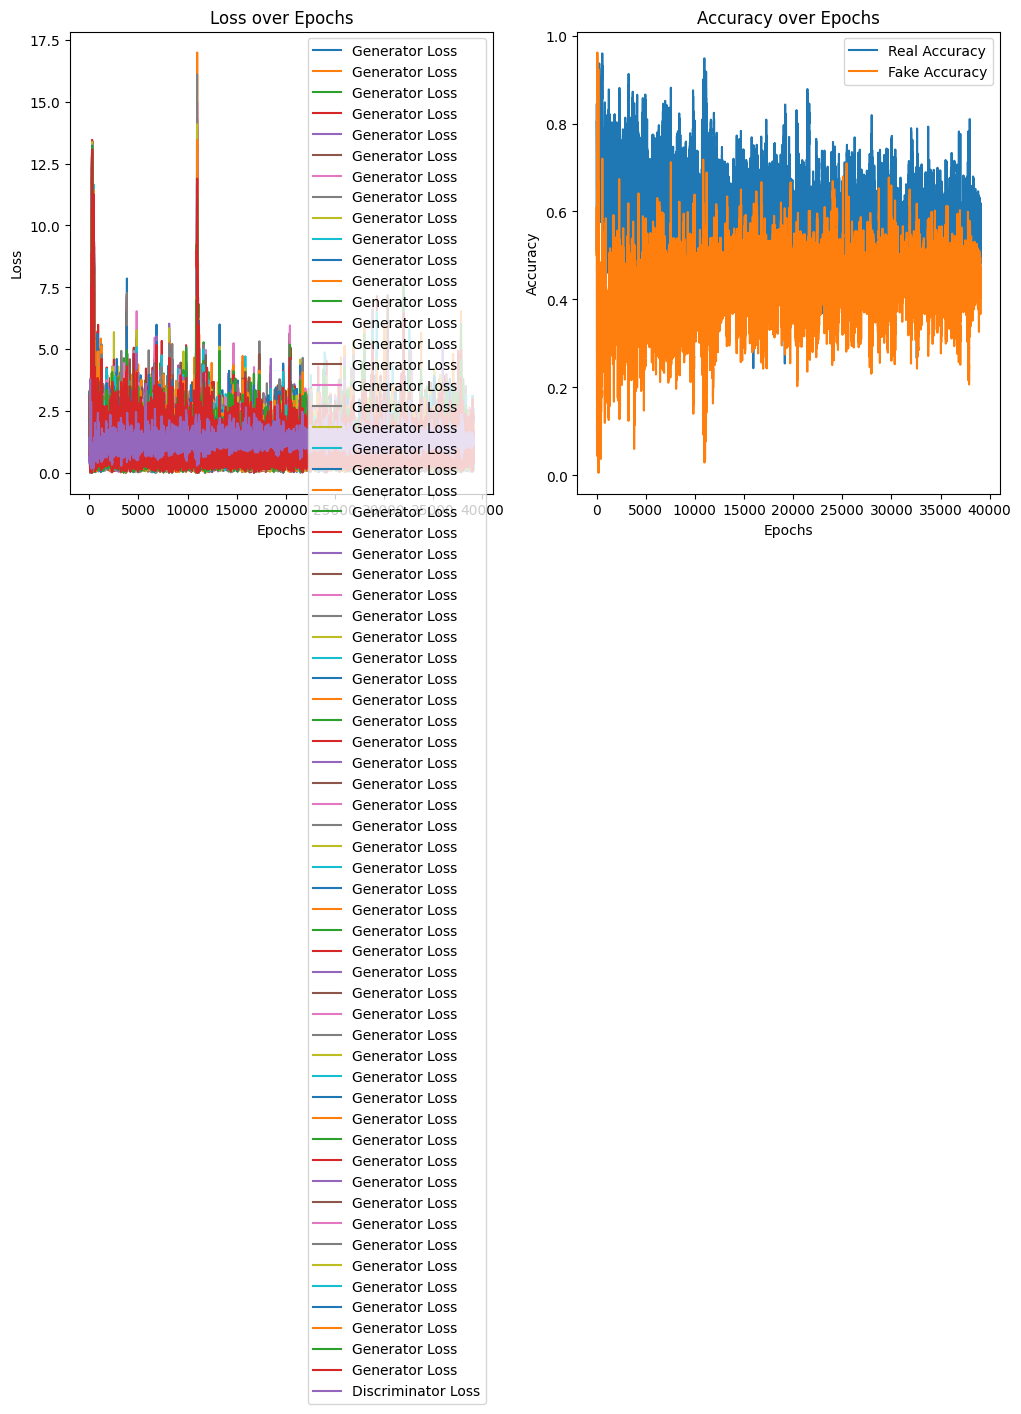

In [ ]:
# 모델 학습
train(train_dataset, EPOCHS, save_every)

In [ ]:
import imageio.v2 as imageio  # imageio.v2로 임포트

# STEP 12: GIF 파일 생성
anim_file = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = sorted(glob.glob(os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples/epoch_*.png')))
    for filename in filenames:
        image = imageio.imread(filename)  # 이 부분은 그대로 유지
        writer.append_data(image)

In [ ]:
# 생성된 GIF 파일 목록 출력
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2406968 Apr 17 06:34 /root/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


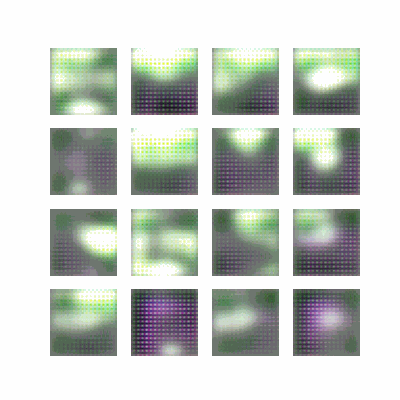

In [ ]:
from IPython.display import Image

# 복사된 GIF 파일을 직접 표시
Image(filename='/content/cifar10_dcgan.gif')

#후기
- 신기했다. 새로운 개념을 알게되는 과정이 재밌었다. GAN은 이미지를 만들기 위한 인공지능 모델로 생성자와 판별자, 라는 2개부분으로 이루어져있다.
- 생성자는 무작위로 노이즈를 받아 새로운 이미지를 그럴듯하게 만들어내고, 판별자는 생성자가 만든 이미지와 실제 이미지를 구분하는 역할을 한다.
- 서로 경쟁하는 구조로 생성자는 더 좋은 이미지를 만들려고 하고, 판별자는 더 정확하게 진짜와 가짜를 구분하려해 시간이 지날수록 더 사실적인 이미지생성이 가능해진다.
- 에포크 시간이 많이 걸려서 다양한 시도를 해보는데 시간이 많이 소요되는 점이 아쉬웠다.
- 어떤 모델을 상용하느냐에 따라 다른 결과를 도출할 수 있다는 걸 알게되었고 구현하고자 하는 목표에 따른 적합한 모델선택이 가장 중요하다고 느꼈다.
- 여전히 에러메시지를 바로바로 수정해나가는 것이 어려웠다.